<a href="https://colab.research.google.com/github/mzouros/dl_gmsa/blob/main/Greek_Music_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Run Colab localy***

jupyter notebook \
  --NotebookApp.allow_origin='https://colab.research.google.com' \
  --port=8888 \
  --NotebookApp.port_retries=0  
  --NotebookApp.iopub_data_rate_limit=1.0e10 

***Resources Overcommit Handling***

cat /proc/sys/vm/overcommit_memory  
echo 1 > /proc/sys/vm/overcommit_memory

In [ ]:
# Host installs

!pip3 install spotipy
!pip3 install pydub
!pip3 install SpecAugment

In [ ]:
# Host model uploads

from google.colab import files
uploaded = files.upload()

Saving arrays.zip to arrays.zip


In [ ]:
# Host unzip models

import zipfile

path_to_zip_file = '/content/arrays.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(path_to_zip_file)


In [ ]:
# Imports

import os
import glob
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cv2 

# .wav conversion and manipulation
from pydub import AudioSegment
from scipy.io import wavfile
import wave

# mel spectograms
import librosa
import librosa.display

# crop soundwaves/spectograms
from PIL import Image

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import neighbors, datasets, svm, metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import LabelEncoder

# keras
from tensorflow import keras
from keras import models, layers
from keras.regularizers import l2
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,Adam
# from keras.utils import np_utils, to_categorical
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.callbacks import EarlyStopping
from keras.datasets import mnist

# increase chunk size to avoid overflow error
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000
plt.rcParams['agg.path.chunksize'] = 100000

# full output of np.arrays
import sys
np.set_printoptions(threshold=sys.maxsize)

%matplotlib inline

In [ ]:
# Dataset size

mp3Path = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MP3'
mp3Count = 0
wmaCount = 0
flacCount = 0
datasetAlbumNames = [] 
datasetTrackNames = []
data = []
dataset = []

for folder in os.listdir(mp3Path):
  trackCount = 0
  datasetAlbumNames.append(folder)
  songPath = mp3Path + '/' + folder
  for song in os.listdir(songPath):
    if song.lower().endswith(".mp3".lower()):
      # print(os.path.join(songPath, song))
      mp3Count += 1
    # for .wma  
    else:
      # print(os.path.join(songPath, song))
      wmaCount += 1
    datasetTrackNames.append(os.path.splitext(song)[0])
    trackCount += 1
  print(folder, trackCount)
  data = [folder, trackCount]
  dataset.append(data)
print("")
print("Total songs found:", mp3Count+wmaCount+flacCount)

# Export to .csv
dataset.sort()
df = pd.DataFrame(dataset, columns = ['artist_name', 'number_of_songs'])
df.to_csv("Final_Dataset.csv", sep = ',')

In [ ]:
# Spotify Developer Credentials

client_id = 'f1947444cbe9421e815b74a771326877'
client_secret = 'a1099b60916440aabc9a24f1583bb73e'

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
# Get the IDs for each playlist of the user

userId = 'mdkyyoecyz3a2cxye8qjvt91l'
playlistIds = []
playlistNames = [] 
offset = 0

userPlaylists1 = sp.user_playlists(userId, offset=0) # 0 - 49
userPlaylists2 = sp.user_playlists(userId, offset=50) # 50 - 99
userPlaylists3 = sp.user_playlists(userId, offset=100) # 100 - 102
for item in userPlaylists1['items']:
  playlistIds.append(item['id'])
  playlistNames.append(item['name'])
for item in userPlaylists2['items']:
  playlistIds.append(item['id'])
  playlistNames.append(item['name'])
for item in userPlaylists3['items']:
  playlistIds.append(item['id'])
  playlistNames.append(item['name'])
print("Playlists' ids:", playlistIds)
print("Playlists' names:", playlistNames)
print("No of Playlists:", len(playlistNames))

In [ ]:
# Validate Spotify's playlists' names against dataset's albums' names
# If it prints nothing, we are good to go

datasetAlbumNames.sort()
playlistNames.sort()

for i in range(102):
  if playlistNames[i] != datasetAlbumNames[i]:
    print("Names [", playlistNames[i], "] and [", datasetAlbumNames[i], "] are not identical. Found on index:", i)

In [ ]:
# Get the IDs for each track of each playlist of the user

user = 'mzouros'
spotifyTrackIds = []
spotifyTrackNames = []

for id in playlistIds:
  # Check size of the playlist
  if sp.user_playlist_tracks(user, id)['total'] < 100:  
    playlist = sp.user_playlist_tracks(user, id)
    for item in playlist['items']:
      track = item['track']
      print(track['artists'][0]['name'], "---", track['name'], "-", track['id'])
      spotifyTrackIds.append(track['id'])
      spotifyTrackNames.append(track['name'])
  elif sp.user_playlist_tracks(user, id)['total'] < 200:
    offset = 0
    for x in range(2):
      playlist = sp.user_playlist_tracks(user, id, offset = offset)
      for item in playlist['items']:
        track = item['track']
        print(track['artists'][0]['name'], "---", track['name'], "-", track['id'])
        spotifyTrackIds.append(track['id'])
        spotifyTrackNames.append(track['name'])
      offset += 100
  else:
    offset = 0
    for x in range(3):
      playlist = sp.user_playlist_tracks(user, id, offset = offset)
      for item in playlist['items']:
        track = item['track']
        print(track['artists'][0]['name'], "---", track['name'], "-", track['id'])
        spotifyTrackIds.append(track['id'])
        spotifyTrackNames.append(track['name'])
      offset += 100

print(len(spotifyTrackIds))

In [ ]:
# Validate Spotify's playlists' tracks' names against dataset's albums' tracks' names
# If it prints zero, we are good to go

missedCount = 0
for track in datasetTrackNames: 
  track = track.replace("_", "/") # song titles with "slashes" on Spotify are saved with "underscore" in our dataset
  if track not in spotifyTrackNames:
    missedCount += 1
    print(track)
print(missedCount)

In [ ]:
# Get Tracks Information and dump them to .csv

tracks = []
for id in spotifyTrackIds:
  try:
    meta = sp.track(id)
    features = sp.audio_features(id)

    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    valence = features[0]['valence']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']

    track = [name, album, artist, release_date, length, popularity, danceability, acousticness, energy, valence, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
    print(track)
    tracks.append(track)
  # We ensure that a faulty id or an empty JSON, won't crash the run  
  except ValueError:
    try:
      print("JSONDecodeError")
    except NameError:
      print("NameError")

# Create metadata/features .csv
df = pd.DataFrame(tracks, columns = ['name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'valence', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])
df.to_csv("Spotify_Tracks.csv", sep = ',')

In [ ]:
# .mp3 to .wav and export (if we want to keep the .wav files)

wavPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/WAV/'

for folder in os.listdir(mp3Path):
  songPath = mp3Path + '/' + folder
  # os.mkdir(wavPath+folder)
  for song in os.listdir(songPath):
    if song.lower().endswith(".mp3".lower()):
      sound = AudioSegment.from_mp3(songPath+'/'+song)
      sound.export(wavPath+folder+'/'+os.path.splitext(song)[0]+'.wav', format="wav")
    # .wma
    else
      sound = AudioSegment.from_file(songPath+'/'+song)
      sound.export(wavPath+folder+'/'+os.path.splitext(song)[0]+'.wav', format="wav")

***We classify each song of our dataset to an emotion, according to the Valence-Arousal dimensional model***

![](https://drive.google.com/uc?export=view&id=1zZapbxBgMSLfRKnqhn6qkR40ZBT2q3Pp)

In [ ]:
# Read Energy (Arousal) and Valence features from .csv and classify each song of the dataset according to the Valence-Arousal dimensional model

spotify_tracks = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Spotify_Tracks.csv'

energyValenceValues = []
artistTrackNames = []
sentiments = []

import csv
with open(spotify_tracks) as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  for row in csv_reader:
    if line_count == 0:
      print ('  Energy  Valence')
      line_count = 1
    else:
      energyValenceValues.append([float(row[9]), float(row[10])])
      artistTrackNames.append([row[3], row[1]])
energyValenceValues = np.array(energyValenceValues)
artistTrackNames = np.array(artistTrackNames)

excitedCount = 0
happyCount = 0
contentCount = 0
calmCount = 0
depressedCount = 0
sadCount = 0
afraidCount = 0
angryCount = 0

for x in energyValenceValues:
  if x[0] >= 0.5 and x[1] >= 0.5 and x[0] >= x[1]:
    sentiments.append('Excited')
    excitedCount += 1
  elif x[0] >= 0.5 and x[1] >= 0.5 and x[0] <= x[1]:
    sentiments.append('Happy')
    happyCount += 1
  elif x[0] <= 0.5 and x[1] >= 0.5 and x[1] - (1 - x[0]) >= 0:
    sentiments.append('Content')
    contentCount += 1
  elif x[0] <= 0.5 and x[1] >= 0.5 and x[1] - (1 - x[0]) <= 0:
    sentiments.append('Calm')
    calmCount += 1
  elif x[0] <= 0.5 and x[1] <= 0.5 and x[0] >= x[1]:
    sentiments.append('Sad')
    depressedCount += 1
  elif x[0] <= 0.5 and x[1] <= 0.5 and x[0] <= x[1]:
    sentiments.append('Depressed')
    sadCount += 1
  elif x[0] >= 0.5 and x[1] <= 0.5 and x[0] - (1 - x[1]) <= 0:
    sentiments.append('Afraid')
    afraidCount += 1
  else:
    sentiments.append('Angry')
    angryCount += 1

sentiments = np.array(sentiments)

# print(energyValenceValues)
# print(artistTrackNames)
# print(sentiments)

# print(energyValenceValues[0])
# print(artistTrackNames[0])
# print(sentiments[0])

# concatenate artistTrackNames with Sentiments and sort by both Album and Track names so we can later match them with the images
artistTrackSentiment = np.concatenate((artistTrackNames, sentiments[:,None]), axis=1)
ind = np.lexsort((artistTrackSentiment[:,1],artistTrackSentiment[:,0]))    


# artistTrackSentiment[ind]
print(artistTrackSentiment)
print(len(artistTrackSentiment))

  Energy  Valence
[['Afroditi Manou' 'Gia Pia Ellada' 'Sad']
 ['Afroditi Manou' 'Nychterini Ekpompi' 'Happy']
 ['Afroditi Manou' 'San Ti Mousiki' 'Afraid']
 ['Afroditi Manou' 'Skini Zilotypias' 'Happy']
 ['Afroditi Manou' "S.A.S. - Skotadi pano ap' tin Athina" 'Happy']
 ['Afroditi Manou' 'Gkazi - Tavros' 'Happy']
 ['Afroditi Manou' 'O Alafroiskiotos' 'Sad']
 ['Afroditi Manou' 'Aspromavri Zoi' 'Happy']
 ['Afroditi Manou' 'Ston Kathrefti' 'Happy']
 ['Afroditi Manou' 'Ma Poios Eisai Telos Panton' 'Happy']
 ['Afroditi Manou' 'Alkool Kai Giasemi' 'Afraid']
 ['Afroditi Manou' "Kai Pou 'Sai Akoma" 'Happy']
 ['Afroditi Manou' 'Vavel' 'Content']
 ['Afroditi Manou' 'Gia Pia Ellada' 'Depressed']
 ['Afroditi Manou' 'Mesanihta Stin Porta Sou' 'Depressed']
 ['Afroditi Manou' "Mou To 'Pan Magi Dekatris" 'Content']
 ['Afroditi Manou' 'Superman' 'Sad']
 ['Afroditi Manou' 'Treli Ti Kathese Ke Les' 'Calm']
 ['Afroditi Manou' 'Aristera Stin Edem' 'Calm']
 ['Afroditi Manou' 'Ipirotiko Tragoudi' 'Content']


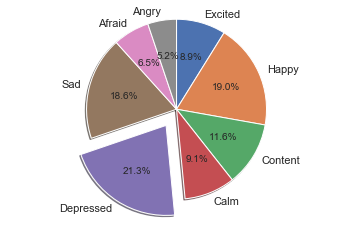


Excited: 463
Happy: 991
Content: 605
Calm: 476
Depressed: 1113
Sad: 970
Afraid: 341
Angry: 270


In [ ]:
# Plot the results of the classification

counts = np.array([excitedCount, happyCount, contentCount, calmCount, depressedCount, sadCount, afraidCount, angryCount])
labels = ["Excited", "Happy", "Content", "Calm", "Depressed", "Sad", "Afraid", "Angry"]
explode = (0, 0, 0, 0, 0.3, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, radius=1.4, counterclock=False)
ax1.axis('equal')
plt.show() 

print('')
print('Excited:', excitedCount)
print('Happy:', happyCount)
print('Content:', contentCount)
print('Calm:', calmCount)
print('Depressed:', depressedCount)
print('Sad:', sadCount)
print('Afraid:', afraidCount)
print('Angry:', angryCount)

In [ ]:
# Transform .mp3 to .wav, export, create soundwaves, spectograms and mel spectograms, free disk space (delete the .wavs)

mp3Path = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MP3'
wavPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/WAV'
spectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Spectograms'
wavePath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Waveforms'
melSpectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MelSpectograms'

for folder in os.listdir(mp3Path):
  songPath = mp3Path + '/' + folder
  # os.mkdir(wavPath+'/'+folder)
  # os.mkdir(spectoPath+'/'+folder)
  # os.mkdir(wavePath+'/'+folder)
  # os.mkdir(melSpectoPath+'/'+folder)
  for song in os.listdir(songPath):
    print(song)
    if song.lower().endswith(".mp3".lower()):
      sound = AudioSegment.from_mp3(songPath+'/'+song)
    # .wma
    else:
      sound = AudioSegment.from_file(songPath+'/'+song)
    songToWav = wavPath+'/'+folder+'/'+os.path.splitext(song)[0]+'.wav'

    # stereo to mono
    sound = sound.set_channels(1)
    sound.export(songToWav, format="wav")

    # create track's spectogram (30 secs)
    samplingFrequency, signalData = wavfile.read(songToWav)
    plt.title('Spectrogram')    
    Pxx, freqs, bins, im = plt.specgram(signalData,Fs=samplingFrequency,NFFT=512)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.xlim(left=0,right=30)
    plt.savefig(spectoPath+'/'+folder+'/'+os.path.splitext(song)[0]+'.png', dpi = 300)
    plt.clf()

    # create track's soundwave (whole songs)
    raw = wave.open(songToWav, "r")
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype ="int16")
    f_rate = raw.getframerate()
    time = np.linspace(0, len(signal) / f_rate, num = len(signal))
    plt.figure(1)
    plt.title("Sound Wave")
    plt.xlabel("Time")
    plt.plot(time, signal)
    plt.savefig(wavePath+'/'+folder+'/'+os.path.splitext(song)[0]+'.png', dpi = 300)
    plt.clf()

    # create track's mel spectogram (whole song)
    y, sr = librosa.load(songToWav)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
    plt.title('Mel Spectrogram');
    plt.colorbar(format='%+2.0f dB');
    plt.savefig(melSpectoPath+'/'+folder+'/'+os.path.splitext(song)[0]+'.png', dpi = 300)
    plt.clf()

    # delete the .wav file (free disk space)
    os.remove(songToWav)

In [ ]:
# Create Laplacian Mel Spectograms (hoping for better accuracy results)

melSpectogramsPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MelSpectograms'
laplacianMelSpectogramsPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Laplacian MelSpectograms'

ddepth = cv2.CV_8U # we define ddepth = CV_16S to avoid overflow
kernel_size = 3 # kernel size of the Sobel operator

for folder in os.listdir(melSpectogramsPath):
  for image in os.listdir(melSpectogramsPath + '/' + folder):
    img = cv2.imread(melSpectogramsPath + '/' + folder + '/' + image)
    resized_image = cv2.resize(img, (256, 256))

    # Remove noise by blurring with a Gaussian filter
    src = cv2.GaussianBlur(resized_image, (3, 3), 0)

    # Apply Laplace function
    dst = cv2.Laplacian(src, ddepth, ksize=kernel_size)

    # Save the image
    cv2.imwrite(laplacianMelSpectogramsPath + '/' + folder + '/' + image , dst)

    # fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    # fig.tight_layout()
    # ax[0].imshow(resized_image)
    # ax[0].set_title("Mel Spectogram")
    # ax[1].imshow(dst)
    # ax[1].set_title("Laplacian Mel Spectogram")
    # plt.show()

In [ ]:
# Trying to fix the bad accuracy results during training, we also create Chromas, CENS and Tonnetz diagrams
# We also try a more catholic strategy with 8k frame rate and 30 sec duration for all our tracks

mp3Path = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MP3'
wavPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/WAV/'
chromaPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Chromas'
censPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/CENS'
tonnetzPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Tonnetz'

for folder in os.listdir(mp3Path):
  songPath = mp3Path + '/' + folder
  for song in os.listdir(songPath):
    if song.lower().endswith(".mp3".lower()):
      sound = AudioSegment.from_mp3(songPath+'/'+song)
    # .wma
    else:
      sound = AudioSegment.from_file(songPath+'/'+song)
    songToWav = wavPath+'/'+folder+'/'+os.path.splitext(song)[0]+'.wav'

    # stereo to mono
    sound = sound.set_channels(1)
    sound = sound.set_frame_rate(8000)
    sound.export(songToWav, format="wav")
    
    y, sr = librosa.load(songToWav)
    chromagram_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chromagram_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

    librosa.display.specshow(chromagram_cqt, y_axis='chroma', fmax=8000, x_axis='time');
    plt.title('Chroma');
    plt.colorbar(format='%+2.0f dB');
    plt.xlim(left=0,right=30)
    plt.savefig(chromaPath+'/'+folder+'/'+os.path.splitext(song)[0]+'.png', dpi = 300)
    plt.clf()

    librosa.display.specshow(chromagram_cens, y_axis='chroma', fmax=8000, x_axis='time');
    plt.title('CENS');
    plt.colorbar(format='%+2.0f dB');
    plt.xlim(left=0,right=30)
    plt.savefig(censPath+'/'+folder+'/'+os.path.splitext(song)[0]+'.png', dpi = 300)
    plt.clf()

    librosa.display.specshow(tonnetz, y_axis='tonnetz', fmax=8000, x_axis='time');
    plt.title('Tonnetz');
    plt.colorbar(format='%+2.0f dB');
    plt.xlim(left=0,right=30)
    plt.savefig(tonnetzPath+'/'+folder+'/'+os.path.splitext(song)[0]+'.png', dpi = 300)
    plt.clf()

    # delete the .wav file (free disk space)
    os.remove(songToWav)

<Figure size 432x288 with 0 Axes>

In [ ]:
# Crop axes from soundwaves, spectograms, mel spectograms, chromas, cens and tonnetz

spectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Spectograms'
wavePath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Waveforms'
melSpectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MelSpectograms'
chromaPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Chromas'
censPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/CENS'
tonnetzPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Tonnetz'

for folder in os.listdir(spectoPath):
  for image in os.listdir(spectoPath+'/'+folder):
    im = Image.open(spectoPath+'/'+folder+'/'+image)
    
    # Setting the points for cropped image
    left = 228
    top = 147
    right = 1618
    bottom = 1048

    croppedImage = im.crop((left, top, right, bottom))
    croppedImage.save(spectoPath+'/'+folder+'/'+image)

for folder in os.listdir(wavePath):
  for image in os.listdir(wavePath+'/'+folder):
    im = Image.open(wavePath+'/'+folder+'/'+image)
    
    # Setting the points for cropped image
    left = 228
    top = 147
    right = 1618
    bottom = 1048

    croppedImage = im.crop((left, top, right, bottom))
    croppedImage.save(wavePath+'/'+folder+'/'+image)

for folder in os.listdir(melSpectoPath):
  for image in os.listdir(melSpectoPath+'/'+folder):
    im = Image.open(melSpectoPath+'/'+folder+'/'+image)
    
    # Setting the points for cropped image
    left = 228
    top = 147
    right = 1339
    bottom = 1048

    croppedImage = im.crop((left, top, right, bottom))
    croppedImage.save(melSpectoPath+'/'+folder+'/'+image)

for folder in os.listdir(chromaPath):
  for image in os.listdir(chromaPath+'/'+folder):
    im = Image.open(chromaPath+'/'+folder+'/'+image)
    
    # Setting the points for cropped image
    left = 228
    top = 147
    right = 1339
    bottom = 1048

    croppedImage = im.crop((left, top, right, bottom))
    croppedImage.save(chromaPath+'/'+folder+'/'+image)

for folder in os.listdir(censPath):
  for image in os.listdir(censPath+'/'+folder):
    im = Image.open(censPath+'/'+folder+'/'+image)
    
    # Setting the points for cropped image
    left = 228
    top = 147
    right = 1339
    bottom = 1048

    croppedImage = im.crop((left, top, right, bottom))
    croppedImage.save(censPath+'/'+folder+'/'+image)

for folder in os.listdir(tonnetzPath):
  for image in os.listdir(tonnetzPath+'/'+folder):
    im = Image.open(tonnetzPath+'/'+folder+'/'+image)
    
    # Setting the points for cropped image
    left = 228
    top = 147
    right = 1339
    bottom = 1048

    croppedImage = im.crop((left, top, right, bottom))
    croppedImage.save(tonnetzPath+'/'+folder+'/'+image)

***We validate that the output .pngs (soundwaves, cens, mel, etc) are of the same 
size (so we can later train our NN)***

***Randomly identifying and validating to 1390x901 resolution for each image***



---


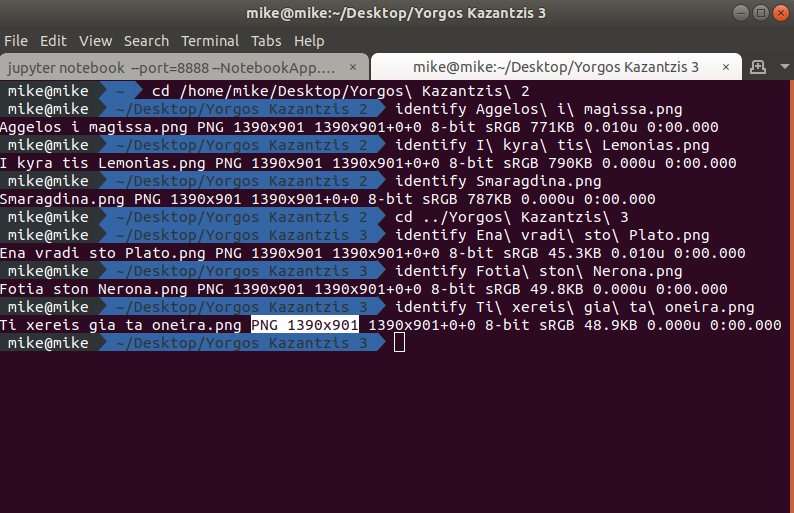

In [ ]:
# -1000 registries when including folder in the if statement. We lose lots of data, because the Artists' name in the .csv from Spotify is different than our folder names.
#  +600 registries when not including folder in the if statement. We got some duplicates (aka noisy data)

spectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Spectograms'
wavePath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Waveforms'
melSpectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MelSpectograms'
laplacianMelSpectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Laplacian MelSpectograms'
chromaPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Chromas'
censPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/CENS'
tonnetzPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Tonnetz'
maskedMelSpectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/SpectAugmentation'


X = []
y = []

i = 0

for x in range(len(artistTrackSentiment)):
  for folder in os.listdir(melSpectoPath):
    for image in os.listdir(melSpectoPath + '/' + folder):
      if '/' in artistTrackSentiment[x][1]:
        artistTrackSentiment[x][1] = artistTrackSentiment[x][1].replace("/", "_")
      if folder == artistTrackSentiment[x][0] and image == artistTrackSentiment[x][1]+'.png':
        i += 1
        img = cv2.imread(melSpectoPath + '/' + folder + '/' + image)
        resized_image = cv2.resize(img, (128, 128))

        # plt.imshow(resized_image)

        # X.append(np.asarray(resized_image))

        if artistTrackSentiment[x][2] == 'Excited':
          # if y.count(0) < 1000:
          X.append(np.asarray(resized_image))
          y.append(0)
        elif artistTrackSentiment[x][2] == 'Happy':
          if y.count(1) < 1000:
            X.append(np.asarray(resized_image))
            y.append(1)
        elif artistTrackSentiment[x][2] == 'Content':
          # if y.count(2) < 500:
          X.append(np.asarray(resized_image))
          y.append(2)
        elif artistTrackSentiment[x][2] == 'Calm':
          # if y.count(3) < 500:
          X.append(np.asarray(resized_image))
          y.append(3)
        elif artistTrackSentiment[x][2] == 'Depressed':
          if y.count(4) < 1000:
            X.append(np.asarray(resized_image))
            y.append(4)
        elif artistTrackSentiment[x][2] == 'Sad':
          if y.count(5) < 1000:
            X.append(np.asarray(resized_image))
            y.append(5)
        elif artistTrackSentiment[x][2] == 'Afraid':
          # if y.count(6) < 500:
          X.append(np.asarray(resized_image))
          y.append(6)
        else:
          # if y.count(7) < 500:
          X.append(np.asarray(resized_image))
          y.append(7)

for x in range(len(artistTrackSentiment)):
  for folder in os.listdir(maskedMelSpectoPath):
    for image in os.listdir(maskedMelSpectoPath + '/' + folder):
      if '/' in artistTrackSentiment[x][1]:
        artistTrackSentiment[x][1] = artistTrackSentiment[x][1].replace("/", "_")
      if folder == artistTrackSentiment[x][0] and image == artistTrackSentiment[x][1]+'.png':
        i += 1
        img = cv2.imread(maskedMelSpectoPath + '/' + folder + '/' + image)
        resized_image = cv2.resize(img, (128, 128))

        # plt.imshow(resized_image)

        # X.append(np.asarray(resized_image))

        if artistTrackSentiment[x][2] == 'Excited':
          # if y.count(0) < 1000:
          X.append(np.asarray(resized_image))
          y.append(0)
        elif artistTrackSentiment[x][2] == 'Happy':
          if y.count(1) < 1000:
            X.append(np.asarray(resized_image))
            y.append(1)
        elif artistTrackSentiment[x][2] == 'Content':
          # if y.count(2) < 500:
          X.append(np.asarray(resized_image))
          y.append(2)
        elif artistTrackSentiment[x][2] == 'Calm':
          # if y.count(3) < 500:
          X.append(np.asarray(resized_image))
          y.append(3)
        elif artistTrackSentiment[x][2] == 'Depressed':
          if y.count(4) < 1000:
            X.append(np.asarray(resized_image))
            y.append(4)
        elif artistTrackSentiment[x][2] == 'Sad':
          if y.count(5) < 1000:
            X.append(np.asarray(resized_image))
            y.append(5)
        elif artistTrackSentiment[x][2] == 'Afraid':
          # if y.count(6) < 500:
          X.append(np.asarray(resized_image))
          y.append(6)
        else:
          # if y.count(7) < 500:
          X.append(np.asarray(resized_image))
          y.append(7)

        # y.append(artistTrackSentiment[x][2])
        # print(X)
        # print(y)

print("Matches found", i)


# Save the X, y np.arrays
np.save('/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MelSpectogramArrays/X.npy', X)
np.save('/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MelSpectogramArrays/y.npy', y)

Matches found 8572


In [ ]:
print(y.count(0))
print(y.count(1))
print(y.count(2))
print(y.count(3))
print(y.count(4))
print(y.count(5))
print(y.count(6))
print(y.count(7))

800
1000
982
806
1000
1000
588
480


In [ ]:
# Load the X, y np.arrays
# X = np.load('/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MelSpectogramArrays/X.npy')
# y = np.load('/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MelSpectogramArrays/y.npy')
# X = np.load('X.npy')
# y = np.load('y.npy')

# one-hot encoding
# label_encoder = LabelEncoder()
# vec = label_encoder.fit_transform(y)

# Normalization for CNN
X = np.stack(X)
X = X.astype('float32')
X = X/255

y = to_categorical(y)
# y=keras.utils.to_categorical(vec, num_classes=8, dtype='float32')

np.array(X).shape
np.array(y).shape

print(X.shape)
print(y.shape)


# CNN Training
# define the data and key parameters in the model
labels = 8

X.shape
y.shape

# Within the total data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=int(0.8*len(X)), random_state=42)

print('Dimensions\n---')
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

(5229, 7)
(5229, 8)
Dimensions
---
X_train (4183, 7)
X_test (1046, 7)
y_train (4183, 8)
y_test (1046, 8)


In [ ]:
# Modeling
input_dimension = (128, 128, 3)

model = Sequential()

# # Layer 1
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_dimension))
# model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # to avoid overfitting

# Layer 2
model.add(Conv2D(32, (3, 3)))
# model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

# Layer 3
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))
model.add(Flatten())

# Layer 4
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Layer 5
model.add(Dense(labels, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation ="relu", input_shape = input_dimension))
# model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Conv2D(64, (3, 3), activation ="relu"))
# model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation ="relu"))
# model.add(layers.Dense(labels, activation ="softmax"))
# model.compile(optimizer ="rmsprop", loss ="categorical_crossentropy", metrics =['accuracy'])


# Training
history = model.fit(X_train, y_train,
          batch_size=16,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))

# save the model
model.save('/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Models/Tonnetz')


27/27 - 18s - loss: 1.3747 - accuracy: 0.3228


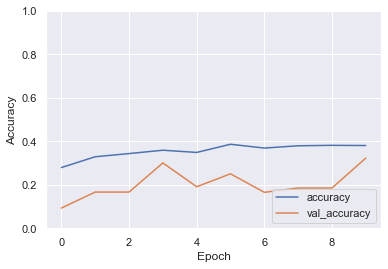

In [ ]:
# Evaluate the model

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)


# train_metrics = history.history[metric]
# val_metrics = history.history['val_'+metric]
# epochs = range(1, len(train_metrics) + 1)
# plt.plot(epochs, train_metrics)
# plt.plot(epochs, val_metrics)
# plt.title('Training and validation '+ metric)
# plt.xlabel("Epochs")
# plt.ylabel(metric)
# plt.legend(["train_"+metric, 'val_'+metric])
# plt.show()

In [ ]:
model = keras.models.load_model('/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Models/Specto')

# CNN Testing
score = model.evaluate(X_test, y_test, verbose=1)
print('accuracy: ',score[1])
print('loss: ',score[0])

# folder_path_test = '/home/mike/Artificial Intelligence MSc/2. Machine Learning/1. Giannakopoulos/Exercises/Images/validation_dof'

# # CNN Validation
# for file_name in os.listdir(folder_path_test):
#     test_pic= []
    
#     image_path = folder_path_test + '/' + file_name
#     img = image.load_img(image_path, target_size=(200, 200))
#     test_pic.append(np.asarray(img))
#     test_pic = np.stack(test_pic)/255.

#     result = (model.predict(test_pic) > 0.5).astype("int32")
#     proba = model.predict(test_pic)
#     print(result, proba)

In [ ]:
# Data Augmentation
# Create Mask Mel Spectograms (filter)
# Script Author: 

mp3Path = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MP3'
wavPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/WAV'
maskedMelSpectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/SpectAugmentation'

for folder in os.listdir(mp3Path):
  songPath = mp3Path + '/' + folder
  for song in os.listdir(songPath):
    print(song)
    if song.lower().endswith(".mp3".lower()):
      sound = AudioSegment.from_mp3(songPath+'/'+song)
    # .wma
    else:
      sound = AudioSegment.from_file(songPath+'/'+song)
    songToWav = wavPath+'/'+folder+'/'+os.path.splitext(song)[0]+'.wav'

    # stereo to mono
    sound = sound.set_channels(1)
    sound.export(songToWav, format="wav")

    # create track's mel spectogram (whole song)
    time_sum = 0
    audio, sampling_rate = librosa.load(songToWav)
    spec = librosa.feature.melspectrogram(y=audio,sr=sampling_rate,n_mels=80, fmax=8000)
    spec = librosa.power_to_db(spec,ref=np.max)
    num = args.num
    print("start to SpecAugment %d times" % num)
    for n in range(num): 
      start = time.time()
      W=40
      T=30
      F=13
      mt=2
      mf=2

      # Nframe : number of spectrum frame
      Nframe = spec.shape[1]
      # Nbin : number of spectrum freq bin
      Nbin = spec.shape[0]
      # check input length
      if Nframe < W*2+1:
          W = int(Nframe/4)
      if Nframe < T*2+1:
          T = int(Nframe/mt)
      if Nbin < F*2+1:
          F = int(Nbin/mf)

      # warping parameter initialize
      w = random.randint(-W,W)
      center = random.randint(W,Nframe-W)

      src = np.asarray([[ float(center),  1], [ float(center),  0], [ float(center),  2], [0, 0], [0, 1], [0, 2], [Nframe-1, 0], [Nframe-1, 1], [Nframe-1, 2]])
      dst = np.asarray([[ float(center+w),  1], [ float(center+w),  0], [ float(center+w),  2], [0, 0], [0, 1], [0, 2], [Nframe-1, 0], [Nframe-1, 1], [Nframe-1, 2]])
      #print(src,dst)

      # source control points
      xs, ys = src[:,0],src[:,1]
      cps = np.vstack([xs, ys]).T
      # target control points
      xt, yt = dst[:,0],dst[:,1]
      # construct TT
      TT = makeT(cps)

      # solve cx, cy (coefficients for x and y)
      xtAug = np.concatenate([xt, np.zeros(3)])
      ytAug = np.concatenate([yt, np.zeros(3)])
      cx = nl.solve(TT, xtAug) # [K+3]
      cy = nl.solve(TT, ytAug)

      # dense grid
      x = np.linspace(0, Nframe-1,Nframe)
      y = np.linspace(1,1,1)
      x, y = np.meshgrid(x, y)

      xgs, ygs = x.flatten(), y.flatten()

      gps = np.vstack([xgs, ygs]).T

      # transform
      pgLift = liftPts(gps, cps) # [N x (K+3)]
      xgt = np.dot(pgLift, cx.T)     
      spec_warped = np.zeros_like(spec)
      for f_ind in range(Nbin):
          spec_tmp = spec[f_ind,:]
          func = interpolate.interp1d(xgt, spec_tmp,fill_value="extrapolate")
          xnew = np.linspace(0, Nframe-1,Nframe)
          spec_warped[f_ind,:] = func(xnew)

      # sample mt of time mask ranges
      t = np.random.randint(T-1, size=mt)+1
      # sample mf of freq mask ranges
      f = np.random.randint(F-1, size=mf)+1
      # mask_t : time mask vector
      mask_t = np.ones((Nframe,1))
      ind = 0
      t_tmp = t.sum() + mt
      for _t in t:
          k = random.randint(ind,Nframe-t_tmp)
          mask_t[k:k+_t] = 0
          ind = k+_t+1
          t_tmp = t_tmp - (_t+1)
      mask_t[ind:] = 1

      # mask_f : freq mask vector
      mask_f = np.ones((Nbin,1))
      ind = 0
      f_tmp = f.sum() + mf
      for _f in f:
          k = random.randint(ind,Nbin-f_tmp)
          mask_f[k:k+_f] = 0
          ind = k+_f+1
          f_tmp = f_tmp - (_f+1)
      mask_f[ind:] = 1

      # calculate mean
      mean = np.mean(spec_warped)

      # make spectrum to zero mean
      spec_zero = spec_warped-mean

      spec_masked = ((spec_zero * mask_t.T) * mask_f) + mean

      end = time.time()
      time_sum += (end - start)  
    librosa.display.specshow(spec_masked, y_axis='mel', fmax=8000, x_axis='time');
    plt.title('Mel Spectrogram');
    plt.colorbar(format='%+2.0f dB');
    plt.savefig(maskedMelSpectoPath+'/'+folder+'/'+os.path.splitext(song)[0]+'.png', dpi = 300)
    plt.clf()

    # delete the .wav file (free disk space)
    os.remove(songToWav)

def makeT(cp):
    K = cp.shape[0]
    T = np.zeros((K+3, K+3))
    T[:K, 0] = 1
    T[:K, 1:3] = cp
    T[K, 3:] = 1
    T[K+1:, 3:] = cp.T
    R = squareform(pdist(cp, metric='euclidean'))
    R = R * R
    R[R == 0] = 1 # a trick to make R ln(R) 0
    R = R * np.log(R)
    np.fill_diagonal(R, 0)
    T[:K, 3:] = R
    return T

def liftPts(p, cp):
    N, K = p.shape[0], cp.shape[0]
    pLift = np.zeros((N, K+3))
    pLift[:,0] = 1
    pLift[:,1:3] = p
    R = cdist(p, cp, 'euclidean')
    R = R * R
    R[R == 0] = 1
    R = R * np.log(R)
    pLift[:,3:] = R
    return pLift

In [ ]:
maskedMelSpectoPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/SpectAugmentation'

for folder in os.listdir(maskedMelSpectoPath):
  for image in os.listdir(maskedMelSpectoPath+'/'+folder):
    im = Image.open(maskedMelSpectoPath+'/'+folder+'/'+image)
    
    # Setting the points for cropped image
    left = 228
    top = 147
    right = 1339
    bottom = 1048

    croppedImage = im.crop((left, top, right, bottom))
    croppedImage.save(maskedMelSpectoPath+'/'+folder+'/'+image)